Adult Dataset

In [6]:
!pip install aif360 imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric



In [10]:
# Load dataset from AIF360
dataset = AdultDataset()

# Split into train and test (already provided in AIF360)
train, test = dataset.split([0.7], shuffle=True)

print("Train size:", len(train.features))
print("Test size:", len(test.features))


Train size: 31655
Test size: 13567


In [44]:
!pip install cvxpy



   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 5.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/887.3 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/887.3 kB ? eta -:--:--
   ----------------------------------- ---- 786.4/887.3 kB 1.3 MB/s eta 0:00:01
   ----------------------------------- ---- 786.4/887.3 kB 1.3 MB/s eta 0:00:01
   -------------------------------------- 887.3/887.3 kB 851.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.5 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.5 MB 670.4 kB/s eta 0:00:11
   -- ------------------------------------- 0.5/7.5 MB 670.4 kB/s eta 0:00:11
   -- ---------------------------------

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from aif360.datasets import AdultDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover, LFR, OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

# ----------------------------
# Step 1: Load Dataset
# ----------------------------
dataset = AdultDataset()
train, test = dataset.split([0.7], shuffle=True)

X_train, y_train = train.features, train.labels.ravel()
X_test, y_test = test.features, test.labels.ravel()

# ----------------------------
# Helper function
# ----------------------------
def evaluate_fairness(test, pred, method_name):
    metric = ClassificationMetric(test, pred,
                                  privileged_groups=[{'sex': 1}],
                                  unprivileged_groups=[{'sex': 0}])
    return {
        'Method': method_name,
        'Accuracy': accuracy_score(test.labels, pred.labels),
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Diff': metric.statistical_parity_difference(),
        'Equal Opportunity Diff': metric.equal_opportunity_difference(),
        'Average Odds Diff': metric.average_odds_difference()
    }

results = []

# ----------------------------
# Baseline
# ----------------------------
clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

pred_dataset = test.copy()
pred_dataset.labels = y_pred.reshape(-1,1)
results.append(evaluate_fairness(test, pred_dataset, "Baseline"))


pip install 'aif360[inFairness]'


In [3]:
rw = Reweighing(unprivileged_groups=[{'sex':0}], privileged_groups=[{'sex':1}])
train_rw = rw.fit_transform(train)

clf_rw = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf_rw.fit(train_rw.features, train_rw.labels.ravel(),
           logisticregression__sample_weight=train_rw.instance_weights)
y_pred_rw = clf_rw.predict(X_test)

pred_rw = test.copy()
pred_rw.labels = y_pred_rw.reshape(-1,1)
results.append(evaluate_fairness(test, pred_rw, "Reweighing"))


In [5]:
dir = DisparateImpactRemover(repair_level=1.0)
train_dir = dir.fit_transform(train)
test_dir = dir.fit_transform(test)

clf_dir = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf_dir.fit(train_dir.features, train_dir.labels.ravel())
y_pred_dir = clf_dir.predict(test_dir.features)

pred_dir = test_dir.copy()
pred_dir.labels = y_pred_dir.reshape(-1,1)
results.append(evaluate_fairness(test_dir, pred_dir, "Disparate Impact Remover"))


In [6]:
lfr = LFR(unprivileged_groups=[{'sex':0}],
          privileged_groups=[{'sex':1}],
          k=10, Ax=0.01, Ay=1.0, Az=2.0,
          verbose=0)

lfr.fit(train)

train_lfr = lfr.transform(train)
test_lfr = lfr.transform(test)

clf_lfr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf_lfr.fit(train_lfr.features, train_lfr.labels.ravel())
y_pred_lfr = clf_lfr.predict(test_lfr.features)

pred_lfr = test_lfr.copy()
pred_lfr.labels = y_pred_lfr.reshape(-1,1)

results.append(evaluate_fairness(test_lfr, pred_lfr, "Learning Fair Representation"))


In [9]:
from aif360.algorithms.preprocessing import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions \
    import get_distortion_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

# Load the Adult dataset (preprocessed for OptimPreproc)
dataset = load_preproc_data_adult(['sex'])
train, test = dataset.split([0.7], shuffle=True)

# Optimizer options
optim_options = {
    "distortion_fun": get_distortion_adult,
    "epsilon": 0.05,
    "clist": [0.99],
    "dlist": [0.1]
}

# Create Optimized Preprocessing instance
OP = OptimPreproc(OptTools,
                  optim_options,
                  unprivileged_groups=[{'sex': 0}],
                  privileged_groups=[{'sex': 1}])

# Fit + transform
OP = OP.fit(train)
train_op = OP.transform(train)
test_op = OP.transform(test)

print("Train samples after Optimized Preprocessing:", train_op.features.shape)







D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc_helpers\data_preproc_functions.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Female': 0.0, 'Male': 1.0})
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc_helpers\opt_tools.py:98: FutureWarning: The default of obse

Optimized Preprocessing: Objective converged to 0.012497


D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:192: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:198: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_tr

Train samples after Optimized Preprocessing: (34189, 18)


D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:192: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:198: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)


In [11]:
# Train classifier on Optimized Preprocessing data
clf_op = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf_op.fit(train_op.features, train_op.labels.ravel())
y_pred_op = clf_op.predict(test_op.features)

# Wrap predictions in dataset format for AIF360 metrics
pred_op = test_op.copy()
pred_op.labels = y_pred_op.reshape(-1, 1)

# Evaluate fairness
results.append(evaluate_fairness(test_op, pred_op, "Optimized Preprocessing"))


In [13]:
results_df = pd.DataFrame(results)
results_df


,Method,Accuracy,Disparate Impact,Statistical Parity Diff,Equal Opportunity Diff,Average Odds Diff
0,Baseline,0.846318,0.273718,-0.191745,-0.114921,-0.101453
1,Reweighing,0.840569,0.570978,-0.094116,0.152422,0.065091
2,Disparate Impact Remover,0.846539,0.279991,-0.178751,-0.109585,-0.093120
3,Learning Fair Representation,1.000000,1.021383,0.020215,0.000000,0.000000
4,Optimized Preprocessing,0.778339,0.431027,-0.122795,-0.278682,-0.166030


In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for i, row in results_df.iterrows():
    plt.scatter(row['Accuracy'], row['Statistical Parity Diff'], label=row['Method'], s=100)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Accuracy")
plt.ylabel("Statistical Parity Diff")
plt.title("Accuracy vs Fairness Tradeoff")
plt.legend()
plt.grid(True)

# Save to file
plt.savefig("accuracy_vs_fairness.png", dpi=300)
print("Plot saved as accuracy_vs_fairness.png")



Plot saved as accuracy_vs_fairness.png


In [78]:
import os
print(os.getcwd())


D:\COLLEGE\Minor


German Dataset

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from aif360.datasets import GermanDataset   # Change here for CompasDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover, LFR


In [57]:
# Load German credit dataset
dataset = GermanDataset()

# 70/30 train-test split
train, test = dataset.split([0.7], shuffle=True)

X_train, y_train = train.features, train.labels.ravel()
X_test, y_test = test.features, test.labels.ravel()


In [59]:
def evaluate_fairness(test, pred, method_name):
    metric = ClassificationMetric(test, pred,
                                  privileged_groups=[{'sex': 1}],   # Privileged group (male)
                                  unprivileged_groups=[{'sex': 0}]) # Unprivileged group (female)
    return {
        'Method': method_name,
        'Accuracy': accuracy_score(test.labels, pred.labels),
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Diff': metric.statistical_parity_difference(),
        'Equal Opportunity Diff': metric.equal_opportunity_difference(),
        'Average Odds Diff': metric.average_odds_difference()
    }

results = []


In [61]:
clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

pred_dataset = test.copy()
pred_dataset.labels = y_pred.reshape(-1,1)

results.append(evaluate_fairness(test, pred_dataset, "Baseline"))


In [63]:
rw = Reweighing(unprivileged_groups=[{'sex':0}], privileged_groups=[{'sex':1}])
train_rw = rw.fit_transform(train)

clf_rw = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf_rw.fit(train_rw.features, train_rw.labels.ravel(),
           logisticregression__sample_weight=train_rw.instance_weights)

y_pred_rw = clf_rw.predict(X_test)
pred_rw = test.copy()
pred_rw.labels = y_pred_rw.reshape(-1,1)

results.append(evaluate_fairness(test, pred_rw, "Reweighing"))


In [65]:
dir = DisparateImpactRemover(repair_level=1.0)
train_dir = dir.fit_transform(train)
test_dir = dir.fit_transform(test)

clf_dir = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf_dir.fit(train_dir.features, train_dir.labels.ravel())
y_pred_dir = clf_dir.predict(test_dir.features)

pred_dir = test_dir.copy()
pred_dir.labels = y_pred_dir.reshape(-1,1)

results.append(evaluate_fairness(test_dir, pred_dir, "Disparate Impact Remover"))


In [69]:
# ----------------------------
# Learning Fair Representation (LFR)
# ----------------------------
from aif360.algorithms.preprocessing import LFR

# Define LFR
lfr = LFR(unprivileged_groups=[{'sex': 0}],
          privileged_groups=[{'sex': 1}],
          k=10, Ax=0.01, Ay=1.0, Az=2.0,
          verbose=0)

# Fit on training set
lfr.fit(train)

# Transform train and test
train_lfr = lfr.transform(train)
test_lfr = lfr.transform(test)

# ✅ Use transformed features but keep original labels
clf_lfr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf_lfr.fit(train_lfr.features, train.labels.ravel())

# Predictions
y_pred_lfr = clf_lfr.predict(test_lfr.features)

# Wrap predictions
pred_lfr = test.copy()
pred_lfr.labels = y_pred_lfr.reshape(-1,1)

# Evaluate fairness
results.append(evaluate_fairness(test, pred_lfr, "Learning Fair Representation"))



In [71]:
# ----------------------------
# Optimized Preprocessing (OP)
# ----------------------------
from aif360.algorithms.preprocessing import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_german
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

# Load German dataset in preprocessed form
dataset_german = load_preproc_data_german(['sex'])
train_g, test_g = dataset_german.split([0.7], shuffle=True)

optim_options = {
    "distortion_fun": get_distortion_german,
    "epsilon": 0.05,
    "clist": [0.99],
    "dlist": [0.1]
}

OP = OptimPreproc(OptTools,
                  optim_options,
                  unprivileged_groups=[{'sex': 0}],
                  privileged_groups=[{'sex': 1}])

OP = OP.fit(train_g)
train_op = OP.transform(train_g)
test_op = OP.transform(test_g)

clf_op = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf_op.fit(train_op.features, train_op.labels.ravel())
y_pred_op = clf_op.predict(test_op.features)

pred_op = test_op.copy()
pred_op.labels = y_pred_op.reshape(-1, 1)

results.append(evaluate_fairness(test_op, pred_op, "Optimized Preprocessing"))


D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc_helpers\data_preproc_functions.py:261: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['personal_status'].replace(status_map)
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc_helpers\opt_tools.py:98: FutureWarning: The default of observed=

Optimized Preprocessing: Objective converged to 0.000000


D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:192: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:198: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_tr

In [73]:
results_df = pd.DataFrame(results)
results_df


,Method,Accuracy,Disparate Impact,Statistical Parity Diff,Equal Opportunity Diff,Average Odds Diff
0,Baseline,0.750000,0.836748,-0.131530,-0.074755,-0.084285
1,Reweighing,0.733333,0.899756,-0.078865,-0.030571,-0.034415
2,Disparate Impact Remover,0.750000,0.836748,-0.131530,-0.074755,-0.084285
3,Learning Fair Representation,0.710000,0.987828,-0.011076,0.006687,0.004916
4,Optimized Preprocessing,0.700000,1.000000,0.000000,0.000000,0.000000


COMPAS Dataset

In [77]:
import pandas as pd

url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df = pd.read_csv(url)

print(df.shape)
print(df.head())


(7214, 53)
   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown            2013-01-13  Male   
4   6  bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
3  1993-01-21   23     Less than 25  African-American  ...               6   
4  1973-01-22   43          25 - 45             Other  ...               1   

   v_score_text  v_screening_date  in_custody  out_

In [81]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from aif360.datasets import CompasDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover, LFR, OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

# ----------------------------
# Step 1: Load COMPAS dataset
# ----------------------------
dataset = CompasDataset()
train, test = dataset.split([0.7], shuffle=True)

X_train, y_train = train.features, train.labels.ravel()
X_test, y_test = test.features, test.labels.ravel()

# ----------------------------
# Helper: Fairness evaluation
# ----------------------------
def evaluate_fairness(test, pred, method_name):
    metric = ClassificationMetric(test, pred,
                                  privileged_groups=[{'race': 1}],   # privileged = Caucasian
                                  unprivileged_groups=[{'race': 0}]) # unprivileged = African-American
    return {
        'Method': method_name,
        'Accuracy': accuracy_score(test.labels, pred.labels),
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Diff': metric.statistical_parity_difference(),
        'Equal Opportunity Diff': metric.equal_opportunity_difference(),
        'Average Odds Diff': metric.average_odds_difference()
    }

results = []

# ----------------------------
# Baseline
# ----------------------------
clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

pred_dataset = test.copy()
pred_dataset.labels = y_pred.reshape(-1,1)
results.append(evaluate_fairness(test, pred_dataset, "Baseline"))

# ----------------------------
# Reweighing
# ----------------------------
rw = Reweighing(unprivileged_groups=[{'race':0}], privileged_groups=[{'race':1}])
train_rw = rw.fit_transform(train)

clf_rw = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf_rw.fit(train_rw.features, train_rw.labels.ravel(),
           logisticregression__sample_weight=train_rw.instance_weights)
y_pred_rw = clf_rw.predict(X_test)

pred_rw = test.copy()
pred_rw.labels = y_pred_rw.reshape(-1,1)
results.append(evaluate_fairness(test, pred_rw, "Reweighing"))

# ----------------------------
# Disparate Impact Remover
# ----------------------------
dir = DisparateImpactRemover(repair_level=1.0)
train_dir = dir.fit_transform(train)
test_dir = dir.fit_transform(test)

clf_dir = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf_dir.fit(train_dir.features, train_dir.labels.ravel())
y_pred_dir = clf_dir.predict(test_dir.features)

pred_dir = test_dir.copy()
pred_dir.labels = y_pred_dir.reshape(-1,1)
results.append(evaluate_fairness(test_dir, pred_dir, "Disparate Impact Remover"))

# ----------------------------
# Learning Fair Representation (LFR)
# ----------------------------
lfr = LFR(unprivileged_groups=[{'race':0}],
          privileged_groups=[{'race':1}],
          k=10, Ax=0.01, Ay=1.0, Az=2.0,
          verbose=0)

lfr.fit(train)

train_lfr = lfr.transform(train)
test_lfr = lfr.transform(test)

clf_lfr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf_lfr.fit(train_lfr.features, train.labels.ravel())  # ✅ keep original labels
y_pred_lfr = clf_lfr.predict(test_lfr.features)

pred_lfr = test.copy()
pred_lfr.labels = y_pred_lfr.reshape(-1,1)

results.append(evaluate_fairness(test, pred_lfr, "Learning Fair Representation"))

# ----------------------------
# Optimized Preprocessing (OP)
# ----------------------------
dataset_compas = load_preproc_data_compas(['race'])
train_c, test_c = dataset_compas.split([0.7], shuffle=True)

optim_options = {
    "distortion_fun": get_distortion_compas,
    "epsilon": 0.05,
    "clist": [0.99],
    "dlist": [0.1]
}

OP = OptimPreproc(OptTools,
                  optim_options,
                  unprivileged_groups=[{'race': 0}],
                  privileged_groups=[{'race': 1}])

OP = OP.fit(train_c)
train_op = OP.transform(train_c)
test_op = OP.transform(test_c)

clf_op = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf_op.fit(train_op.features, train_op.labels.ravel())
y_pred_op = clf_op.predict(test_op.features)

pred_op = test_op.copy()
pred_op.labels = y_pred_op.reshape(-1, 1)

results.append(evaluate_fairness(test_op, pred_op, "Optimized Preprocessing"))

# ----------------------------
# Final Results
# ----------------------------
results_df = pd.DataFrame(results)
print(results_df)


D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc_helpers\data_preproc_functions.py:163: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfcutQ['sex'] = dfcutQ['sex'].replace({'Female': 1.0, 'Male': 0.0})
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc_helpers\opt_tools.py:98: FutureWarning: The defaul

Optimized Preprocessing: Objective converged to 0.000000


D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:192: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:198: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_tr

                         Method  Accuracy  Disparate Impact  \
0                      Baseline  0.665046          0.777021   
1                    Reweighing  0.661264          0.986979   
2      Disparate Impact Remover  0.685035          0.819990   
3  Learning Fair Representation  0.668287          0.903861   
4       Optimized Preprocessing  0.659722          0.914480   

   Statistical Parity Diff  Equal Opportunity Diff  Average Odds Diff  
0                -0.160475               -0.096416          -0.132802  
1                -0.008018                0.039685           0.024775  
2                -0.137205               -0.067316          -0.106496  
3                -0.065253               -0.010581          -0.033698  
4                -0.053551               -0.040876          -0.046831  


D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:192: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)
D:\COLLEGE\Minor\aif360\algorithms\preprocessing\optim_preproc.py:198: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_tr

In-processing Algorithm

In [7]:
!pip install fairlearn


  Using cached fairlearn-0.12.0-py3-none-any.whl.metadata (7.0 kB)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from aif360.datasets import AdultDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.inprocessing import (
    AdversarialDebiasing,
    PrejudiceRemover,
    MetaFairClassifier,
    GerryFairClassifier
)
from fairlearn.reductions import GridSearch, ExponentiatedGradient, DemographicParity, EqualizedOdds

# ================================
# Load dataset
# ================================
dataset = AdultDataset()
train, test = dataset.split([0.7], shuffle=True)

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

# ================================
# Helper: Evaluate fairness/accuracy
# ================================
def evaluate_fairness(test, pred, method_name):
    metric = ClassificationMetric(test, pred,
                                  privileged_groups=privileged_groups,
                                  unprivileged_groups=unprivileged_groups)
    return {
        'Method': method_name,
        'Accuracy': accuracy_score(test.labels, pred.labels),
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Diff': metric.statistical_parity_difference(),
        'Equal Opportunity Diff': metric.equal_opportunity_difference(),
        'Average Odds Diff': metric.average_odds_difference()
    }

results = []

# ================================
# 1. Baseline Logistic Regression
# ================================
X_train, y_train = train.features, train.labels.ravel()
X_test, y_test = test.features, test.labels.ravel()

lr = LogisticRegression(max_iter=1000, solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Wrap predictions into an AIF360 dataset (so metrics align)
from aif360.datasets import BinaryLabelDataset
pred_baseline = test.copy(deepcopy=True)
pred_baseline.labels = y_pred.reshape(-1,1)

results.append(evaluate_fairness(test, pred_baseline, "Baseline Logistic Regression"))

pip install 'aif360[inFairness]'


In [3]:
sess = tf.compat.v1.Session()

adv_debiasing = AdversarialDebiasing(privileged_groups=privileged_groups,
                                     unprivileged_groups=unprivileged_groups,
                                     scope_name='adv_debiasing',
                                     debias=True,
                                     sess=sess)
adv_debiasing.fit(train)
pred_adv = adv_debiasing.predict(test)
results.append(evaluate_fairness(test, pred_adv, "Adversarial Debiasing"))
sess.close()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 10.160891; batch adversarial loss: 0.951211
epoch 0; iter: 200; batch classifier loss: 7.285981; batch adversarial loss: 0.706959
epoch 1; iter: 0; batch classifier loss: 8.019659; batch adversarial loss: 0.670092
epoch 1; iter: 200; batch classifier loss: 4.901203; batch adversarial loss: 0.706375
epoch 2; iter: 0; batch classifier loss: 3.775906; batch adversarial loss: 0.654836
epoch 2; iter: 200; batch classifier loss: 3.449643; batch adversarial loss: 0.642440
epoch 3; iter: 0; batch classifier loss: 2.219460; batch adversarial loss: 0.591713
epoch 3; iter: 200; batch classifier loss: 2.311722; batch adversarial loss: 0.624032
epoch 4; iter: 0; batch classifier loss: 1.344127; batch adversarial loss: 0.644373
epoch 4; iter: 200; batch classifier loss: 0.684038; batch adversarial loss: 0.622640
epoch 5; iter: 0; batch classifier loss: 0.695884; batch adversarial loss: 0.616677
epoch 5; iter: 200; batch classifier loss: 0.355062; batch advers

In [5]:
pr = PrejudiceRemover(sensitive_attr='sex', eta=25.0)
pr.fit(train)
pred_pr = pr.predict(test)
results.append(evaluate_fairness(test, pred_pr, "Prejudice Remover"))

In [7]:
mf = MetaFairClassifier(tau=0.5, sensitive_attr="sex")
mf.fit(train)
pred_mf = mf.predict(test)
results.append(evaluate_fairness(test, pred_mf, "MetaFair Classifier"))

In [9]:
gs = GridSearch(estimator=LogisticRegression(solver='liblinear'),
                constraints=DemographicParity(),
                grid_size=10)
gs.fit(train.features, train.labels.ravel(), sensitive_features=train.protected_attributes[:,0])
y_pred_gs = gs.predict(test.features)
pred_gs = test.copy()
pred_gs.labels = y_pred_gs.reshape(-1,1)
results.append(evaluate_fairness(test, pred_gs, "Grid Search Reduction"))

In [11]:
eg = ExponentiatedGradient(estimator=LogisticRegression(solver='liblinear'),
                           constraints=EqualizedOdds())
eg.fit(train.features, train.labels.ravel(), sensitive_features=train.protected_attributes[:,0])
y_pred_eg = eg.predict(test.features)
pred_eg = test.copy()
pred_eg.labels = y_pred_eg.reshape(-1,1)
results.append(evaluate_fairness(test, pred_eg, "Exponentiated Gradient Reduction"))

In [13]:
gerry = GerryFairClassifier(C=100, printflag=False)
gerry.fit(train)
pred_gerry = gerry.predict(test)
results.append(evaluate_fairness(test, pred_gerry, "GerryFair Classifier"))

In [15]:
results_df = pd.DataFrame(results)
display(results_df)

,Method,Accuracy,Disparate Impact,Statistical Parity Diff,Equal Opportunity Diff,Average Odds Diff
0,Baseline Logistic Regression,0.845139,0.306839,-0.177614,-0.096467,-0.085132
1,Adversarial Debiasing,0.839758,0.567882,-0.102486,0.106534,0.043434
2,Prejudice Remover,0.845729,0.307727,-0.179950,-0.091032,-0.083692
3,MetaFair Classifier,0.737156,0.394796,-0.358085,-0.107134,-0.192011
4,Grid Search Reduction,0.840790,0.341680,-0.158071,-0.059002,-0.060728
5,Exponentiated Gradient Reduction,0.843370,0.317909,-0.171136,-0.082534,-0.076531
6,GerryFair Classifier,0.755362,0.174320,-0.009715,-0.019273,-0.009717


Post-Processing

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
from aif360.datasets import AdultDataset
from aif360.metrics import ClassificationMetric

# Load dataset
dataset = AdultDataset()
train, test = dataset.split([0.7], shuffle=True)

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

# Helper function for evaluation
def evaluate_fairness(test, pred, method_name):
    metric = ClassificationMetric(test, pred,
                                  privileged_groups=privileged_groups,
                                  unprivileged_groups=unprivileged_groups)
    return {
        'Method': method_name,
        'Accuracy': accuracy_score(test.labels, pred.labels),
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Diff': metric.statistical_parity_difference(),
        'Equal Opportunity Diff': metric.equal_opportunity_difference(),
        'Average Odds Diff': metric.average_odds_difference()
    }

results = []



In [27]:
from aif360.algorithms.postprocessing import (
    RejectOptionClassification,
    EqOddsPostprocessing,
    CalibratedEqOddsPostprocessing
)

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from aif360.algorithms.postprocessing import (
    RejectOptionClassification,
    EqOddsPostprocessing,
    CalibratedEqOddsPostprocessing
)
import pandas as pd

results = []

# ---- Baseline Logistic Regression ----
clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf.fit(train.features, train.labels.ravel())

y_pred = clf.predict(test.features)
baseline_acc = accuracy_score(test.labels, y_pred)

# Build AIF360 dataset for predictions
pred_dataset = test.copy()
pred_dataset.labels = y_pred.reshape(-1,1)

fairness_metrics = evaluate_fairness(test, pred_dataset, "Baseline")
fairness_metrics["Accuracy"] = baseline_acc
results.append(fairness_metrics)


# ---- Reject Option Classification ----
# Needs probability scores
test_pred = test.copy(deepcopy=True)
test_pred.scores = clf.predict_proba(test.features)[:, 1].reshape(-1,1)
test_pred.labels = y_pred.reshape(-1,1)

roc = RejectOptionClassification(unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups)
roc.fit(test, test_pred)
pred_roc = roc.predict(test_pred)

fairness_metrics = evaluate_fairness(test, pred_roc, "Reject Option Classification")
fairness_metrics["Accuracy"] = accuracy_score(test.labels, pred_roc.labels)
results.append(fairness_metrics)


# ---- Equalized Odds ----
eq_odds = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups,
                               privileged_groups=privileged_groups)
eq_odds.fit(test, test_pred)
pred_eq = eq_odds.predict(test_pred)

fairness_metrics = evaluate_fairness(test, pred_eq, "Equalized Odds Postprocessing")
fairness_metrics["Accuracy"] = accuracy_score(test.labels, pred_eq.labels)
results.append(fairness_metrics)


# ---- Calibrated Equalized Odds ----
cal_eq = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups,
                                        cost_constraint="fnr")
cal_eq.fit(test, test_pred)
pred_cal = cal_eq.predict(test_pred)

fairness_metrics = evaluate_fairness(test, pred_cal, "Calibrated Equalized Odds")
fairness_metrics["Accuracy"] = accuracy_score(test.labels, pred_cal.labels)
results.append(fairness_metrics)


# ---- Results as DataFrame ----
df_results = pd.DataFrame(results)
print(df_results)


                          Method  Accuracy  Disparate Impact  \
0                       Baseline  0.846318          0.299872   
1   Reject Option Classification  0.779465          0.872746   
2  Equalized Odds Postprocessing  0.815140          0.612341   
3      Calibrated Equalized Odds  0.818825          0.433998   

   Statistical Parity Diff  Equal Opportunity Diff  Average Odds Diff  
0                -0.186992               -0.115705          -0.097515  
1                -0.049944                0.165184           0.108625  
2                -0.089805               -0.007748          -0.003999  
3                -0.104451                0.080469           0.015799  


In [31]:
results_df = pd.DataFrame(results)
display(results_df)

,Method,Accuracy,Disparate Impact,Statistical Parity Diff,Equal Opportunity Diff,Average Odds Diff
0,Baseline,0.846318,0.299872,-0.186992,-0.115705,-0.097515
1,Reject Option Classification,0.779465,0.872746,-0.049944,0.165184,0.108625
2,Equalized Odds Postprocessing,0.815140,0.612341,-0.089805,-0.007748,-0.003999
3,Calibrated Equalized Odds,0.818825,0.433998,-0.104451,0.080469,0.015799


German Dataset

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from aif360.datasets import GermanDataset
from aif360.metrics import ClassificationMetric

# -------------------------------
# Helper function for fairness evaluation
# -------------------------------
def evaluate_fairness(test, pred, method_name, privileged_groups, unprivileged_groups):
    metric = ClassificationMetric(test, pred,
                                  privileged_groups=privileged_groups,
                                  unprivileged_groups=unprivileged_groups)
    return {
        'Method': method_name,
        'Accuracy': accuracy_score(test.labels, pred.labels),
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Diff': metric.statistical_parity_difference(),
        'Equal Opportunity Diff': metric.equal_opportunity_difference(),
        'Average Odds Diff': metric.average_odds_difference()
    }

# -------------------------------
# German Dataset
# -------------------------------
german = GermanDataset()
train, test = german.split([0.7], shuffle=True)

# Privileged: age > 25 → encoded as 1, Unprivileged: age <= 25 → encoded as 0
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

# Dummy baseline (all positive predictions, replace with classifier if needed)
pred = test.copy()
pred.labels = np.ones_like(test.labels)

# Evaluate fairness
results = evaluate_fairness(test, pred, "German Baseline", 
                            privileged_groups, unprivileged_groups)

df_results = pd.DataFrame([results])
print(df_results)


            Method  Accuracy  Disparate Impact  Statistical Parity Diff  \
0  German Baseline  0.706667               1.0                      0.0   

   Equal Opportunity Diff  Average Odds Diff  
0                     0.0                0.0  


In [17]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from aif360.datasets import GermanDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.postprocessing import (
    RejectOptionClassification,
    EqOddsPostprocessing,
    CalibratedEqOddsPostprocessing
)

# -------------------------------
# Helper function for fairness evaluation
# -------------------------------
def evaluate_fairness(test, pred, method_name, privileged_groups, unprivileged_groups):
    metric = ClassificationMetric(test, pred,
                                  privileged_groups=privileged_groups,
                                  unprivileged_groups=unprivileged_groups)
    return {
        'Method': method_name,
        'Accuracy': accuracy_score(test.labels, pred.labels),
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Diff': metric.statistical_parity_difference(),
        'Equal Opportunity Diff': metric.equal_opportunity_difference(),
        'Average Odds Diff': metric.average_odds_difference()
    }

# -------------------------------
# Load German Dataset
# -------------------------------
german = GermanDataset()
train, test = german.split([0.7], shuffle=True)

# Privileged: age > 25 (1), Unprivileged: age <= 25 (0)
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

# -------------------------------
# Baseline Logistic Regression
# -------------------------------
X_train = train.features
y_train = train.labels.ravel()
X_test = test.features
y_test = test.labels.ravel()

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_scores = clf.predict_proba(X_test)[:, 1]

# Baseline prediction dataset
test_pred = test.copy()
test_pred.scores = y_scores.reshape(-1,1)
test_pred.labels = y_pred.reshape(-1,1)

results = []
results.append(evaluate_fairness(test, test_pred, "Baseline",
                                 privileged_groups, unprivileged_groups))

# -------------------------------
# Reject Option Classification
# -------------------------------
roc = RejectOptionClassification(unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups)
roc.fit(test, test_pred)
pred_roc = roc.predict(test_pred)
results.append(evaluate_fairness(test, pred_roc, "Reject Option Classification",
                                 privileged_groups, unprivileged_groups))

# -------------------------------
# Equalized Odds Postprocessing
# -------------------------------
eq_odds = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups,
                               privileged_groups=privileged_groups)
eq_odds.fit(test, test_pred)
pred_eq = eq_odds.predict(test_pred)
results.append(evaluate_fairness(test, pred_eq, "Equalized Odds Postprocessing",
                                 privileged_groups, unprivileged_groups))

# -------------------------------
# Calibrated Equalized Odds
# -------------------------------
cal_eq = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups,
                                        cost_constraint="fnr")
cal_eq.fit(test, test_pred)
pred_cal = cal_eq.predict(test_pred)
results.append(evaluate_fairness(test, pred_cal, "Calibrated Equalized Odds",
                                 privileged_groups, unprivileged_groups))

# -------------------------------
# Final Results
# -------------------------------
df_results = pd.DataFrame(results)
print(df_results)


                          Method  Accuracy  Disparate Impact  \
0                       Baseline  0.773333          0.823792   
1   Reject Option Classification  0.280000               NaN   
2  Equalized Odds Postprocessing  0.743333          0.923215   
3      Calibrated Equalized Odds  0.226667          1.780924   

   Statistical Parity Diff  Equal Opportunity Diff  Average Odds Diff  
0                -0.143768               -0.100000          -0.081186  
1                 0.000000                0.000000           0.000000  
2                -0.055902               -0.016667           0.011328  
3                 0.143768                0.100000           0.081186  


D:\COLLEGE\Minor\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


In [19]:
results_df = pd.DataFrame(results)
display(results_df)

,Method,Accuracy,Disparate Impact,Statistical Parity Diff,Equal Opportunity Diff,Average Odds Diff
0,Baseline,0.773333,0.823792,-0.143768,-0.100000,-0.081186
1,Reject Option Classification,0.280000,NaN,0.000000,0.000000,0.000000
2,Equalized Odds Postprocessing,0.743333,0.923215,-0.055902,-0.016667,0.011328
3,Calibrated Equalized Odds,0.226667,1.780924,0.143768,0.100000,0.081186


In [21]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from aif360.datasets import CompasDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.postprocessing import (
    RejectOptionClassification,
    EqOddsPostprocessing,
    CalibratedEqOddsPostprocessing
)

# -------------------------------
# Helper function for fairness evaluation
# -------------------------------
def evaluate_fairness(test, pred, method_name, privileged_groups, unprivileged_groups):
    metric = ClassificationMetric(test, pred,
                                  privileged_groups=privileged_groups,
                                  unprivileged_groups=unprivileged_groups)
    return {
        'Method': method_name,
        'Accuracy': accuracy_score(test.labels, pred.labels),
        'Disparate Impact': metric.disparate_impact(),
        'Statistical Parity Diff': metric.statistical_parity_difference(),
        'Equal Opportunity Diff': metric.equal_opportunity_difference(),
        'Average Odds Diff': metric.average_odds_difference()
    }

# -------------------------------
# Load German Dataset
# -------------------------------


# Load COMPAS dataset
compas = CompasDataset()
train, test = compas.split([0.7], shuffle=True)

# Privileged: race = Caucasian (1), Unprivileged: Non-Caucasian (0)
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

# (everything else is identical to German code above)

# -------------------------------
# Baseline Logistic Regression
# -------------------------------
X_train = train.features
y_train = train.labels.ravel()
X_test = test.features
y_test = test.labels.ravel()

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_scores = clf.predict_proba(X_test)[:, 1]

# Baseline prediction dataset
test_pred = test.copy()
test_pred.scores = y_scores.reshape(-1,1)
test_pred.labels = y_pred.reshape(-1,1)

results = []
results.append(evaluate_fairness(test, test_pred, "Baseline",
                                 privileged_groups, unprivileged_groups))

# -------------------------------
# Reject Option Classification
# -------------------------------
roc = RejectOptionClassification(unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups)
roc.fit(test, test_pred)
pred_roc = roc.predict(test_pred)
results.append(evaluate_fairness(test, pred_roc, "Reject Option Classification",
                                 privileged_groups, unprivileged_groups))

# -------------------------------
# Equalized Odds Postprocessing
# -------------------------------
eq_odds = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups,
                               privileged_groups=privileged_groups)
eq_odds.fit(test, test_pred)
pred_eq = eq_odds.predict(test_pred)
results.append(evaluate_fairness(test, pred_eq, "Equalized Odds Postprocessing",
                                 privileged_groups, unprivileged_groups))

# -------------------------------
# Calibrated Equalized Odds
# -------------------------------
cal_eq = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups,
                                        cost_constraint="fnr")
cal_eq.fit(test, test_pred)
pred_cal = cal_eq.predict(test_pred)
results.append(evaluate_fairness(test, pred_cal, "Calibrated Equalized Odds",
                                 privileged_groups, unprivileged_groups))

# -------------------------------
# Final Results
# -------------------------------
df_results = pd.DataFrame(results)
print(df_results)

                          Method  Accuracy  Disparate Impact  \
0                       Baseline  0.670448          0.873882   
1   Reject Option Classification  0.554835          0.999463   
2  Equalized Odds Postprocessing  0.645597          0.948679   
3      Calibrated Equalized Odds  0.329552          1.249900   

   Statistical Parity Diff  Equal Opportunity Diff  Average Odds Diff  
0                -0.083817               -0.003807          -0.050967  
1                -0.000526                0.006961          -0.003150  
2                -0.034107                0.007520          -0.000312  
3                 0.083817                0.003807           0.050967  


In [23]:
results_df = pd.DataFrame(results)
display(results_df)

,Method,Accuracy,Disparate Impact,Statistical Parity Diff,Equal Opportunity Diff,Average Odds Diff
0,Baseline,0.670448,0.873882,-0.083817,-0.003807,-0.050967
1,Reject Option Classification,0.554835,0.999463,-0.000526,0.006961,-0.003150
2,Equalized Odds Postprocessing,0.645597,0.948679,-0.034107,0.007520,-0.000312
3,Calibrated Equalized Odds,0.329552,1.249900,0.083817,0.003807,0.050967


Graph

Final

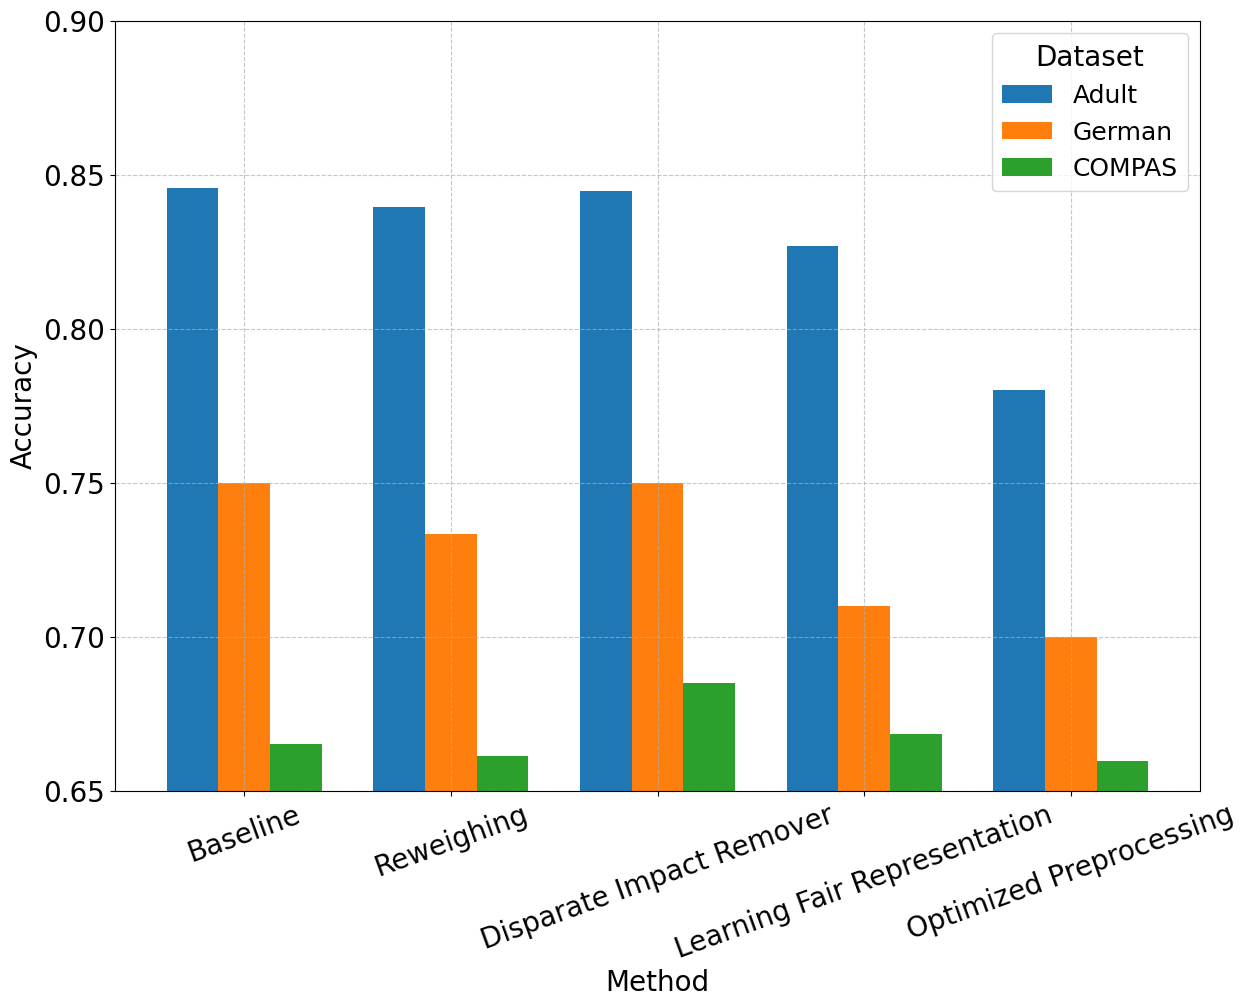

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# ================================
# Data
# ================================
data = {
    "Method": ["Baseline", "Reweighing", "Disparate Impact Remover",
               "Learning Fair Representation", "Optimized Preprocessing"],
    "Adult": [0.845581, 0.839611, 0.844697, 0.826941, 0.780250],
    "German": [0.750000, 0.733333, 0.750000, 0.710000, 0.700000],
    "COMPAS": [0.665046, 0.661264, 0.685035, 0.668287, 0.659722]
}
df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(14,10))  # increased height
df.set_index("Method").plot(kind="bar", ax=ax, width=0.75)

# Labels and formatting
plt.xlabel("Method", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.xticks(rotation=20, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0.65, 0.9)
plt.legend(title="Dataset", fontsize=18, title_fontsize=20)

# Grid background for both X and Y axes
plt.grid(True, axis="both", linestyle="--", alpha=0.7)

plt.show()






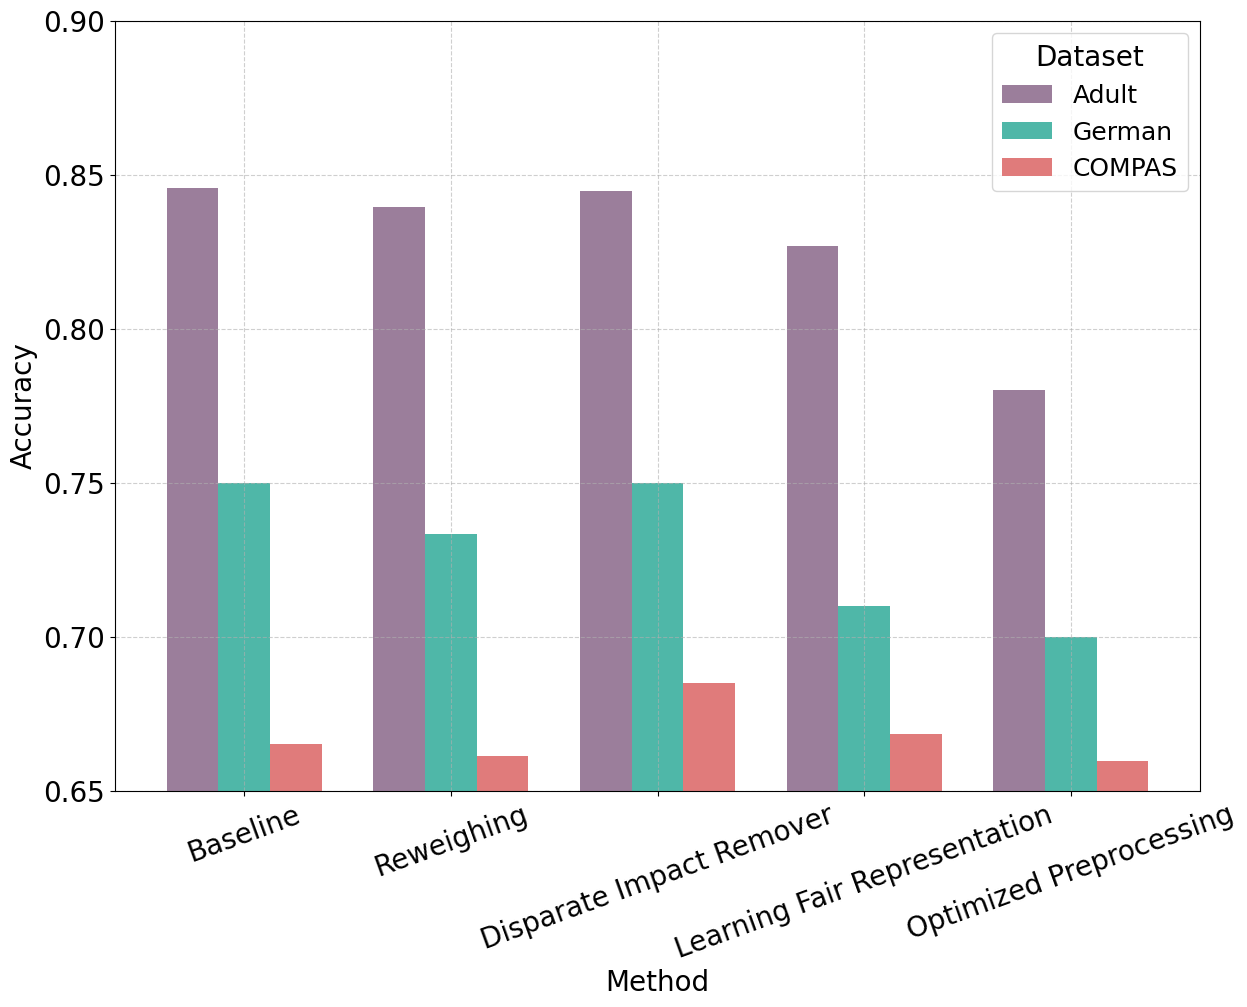

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# ================================
# Data
# ================================
data = {
    "Method": ["Baseline", "Reweighing", "Disparate Impact Remover",
               "Learning Fair Representation", "Optimized Preprocessing"],
    "Adult": [0.845581, 0.839611, 0.844697, 0.826941, 0.780250],
    "German": [0.750000, 0.733333, 0.750000, 0.710000, 0.700000],
    "COMPAS": [0.665046, 0.661264, 0.685035, 0.668287, 0.659722]
}
df = pd.DataFrame(data)

# ================================
# Plot
# ================================
fig, ax = plt.subplots(figsize=(14,10))

# Darker pastel palette
darker_colors = ["#9B7E9B", "#4FB7A8", "#E07B7B"]

df.set_index("Method").plot(kind="bar", ax=ax, width=0.75, color=darker_colors)

# Labels and formatting
plt.xlabel("Method", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.xticks(rotation=20, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0.65, 0.9)
plt.legend(title="Dataset", fontsize=18, title_fontsize=20)

# Grid background
plt.grid(True, axis="both", linestyle="--", alpha=0.6)

plt.show()


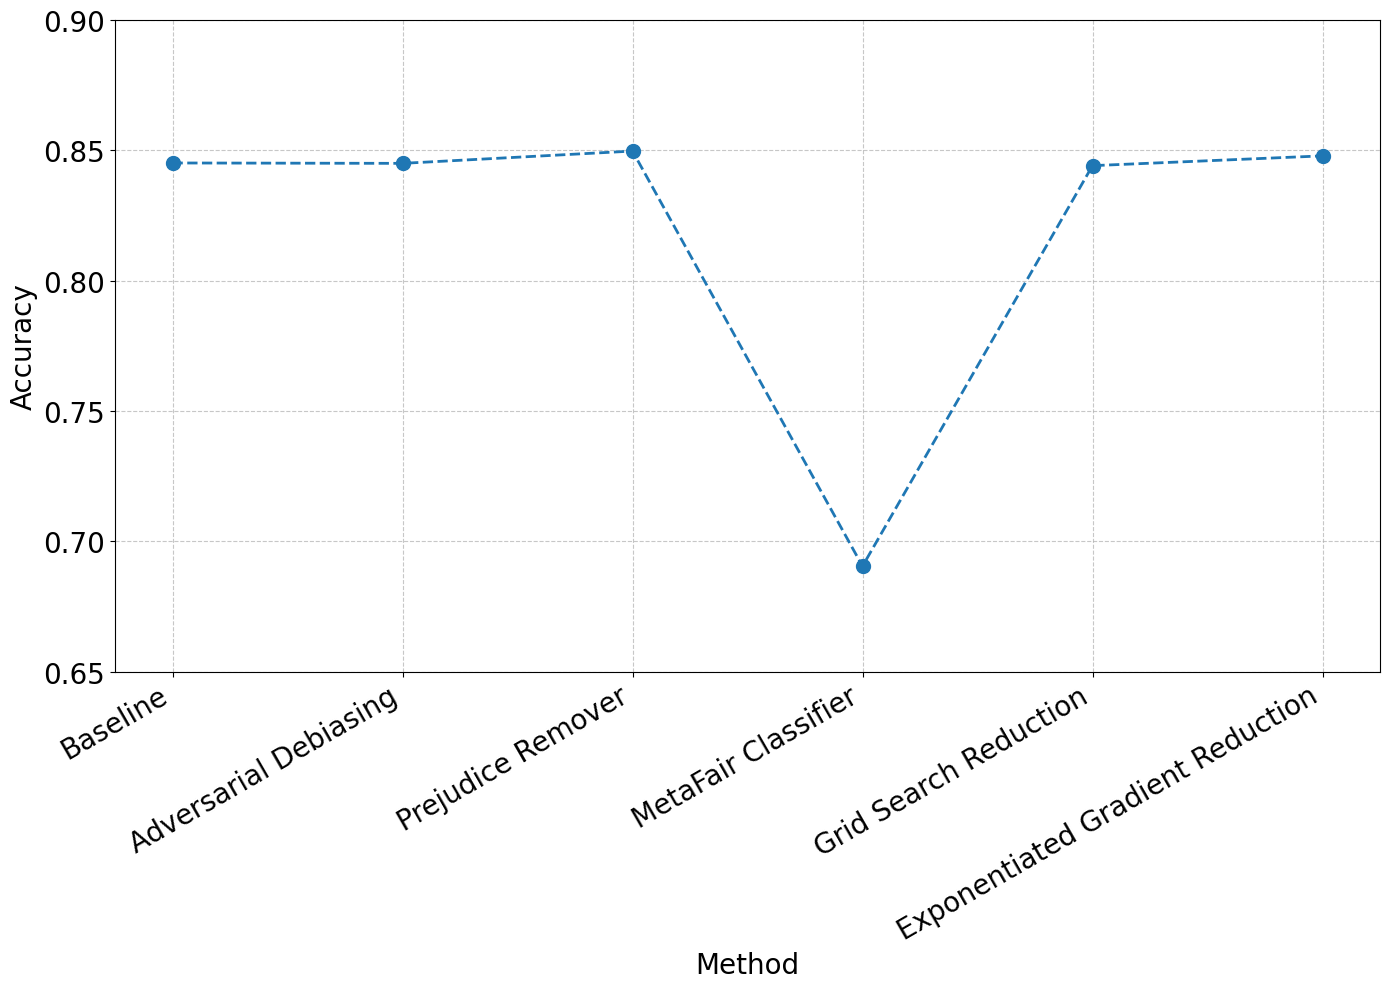

In [33]:
import matplotlib.pyplot as plt

# Data
data = {
    "Method": [
        "Baseline",
        "Adversarial Debiasing",
        "Prejudice Remover",
        "MetaFair Classifier",
        "Grid Search Reduction",
        "Exponentiated Gradient Reduction"
    ],
    "Accuracy": [
        0.845139,
        0.844992,
        0.849709,
        0.690425,
        0.844107,
        0.847866
    ]
}

fig, ax = plt.subplots(figsize=(14,10))  # increased height from 6 → 8
methods = data["Method"]
accuracy = data["Accuracy"]

ax.plot(methods, accuracy, marker="o", linestyle="--", linewidth=2, markersize=10)

# Labels and formatting
plt.xlabel("Method", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.xticks(rotation=30, ha="right", fontsize=20)
plt.yticks(fontsize=20)

plt.ylim(0.65, 0.9)
plt.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()






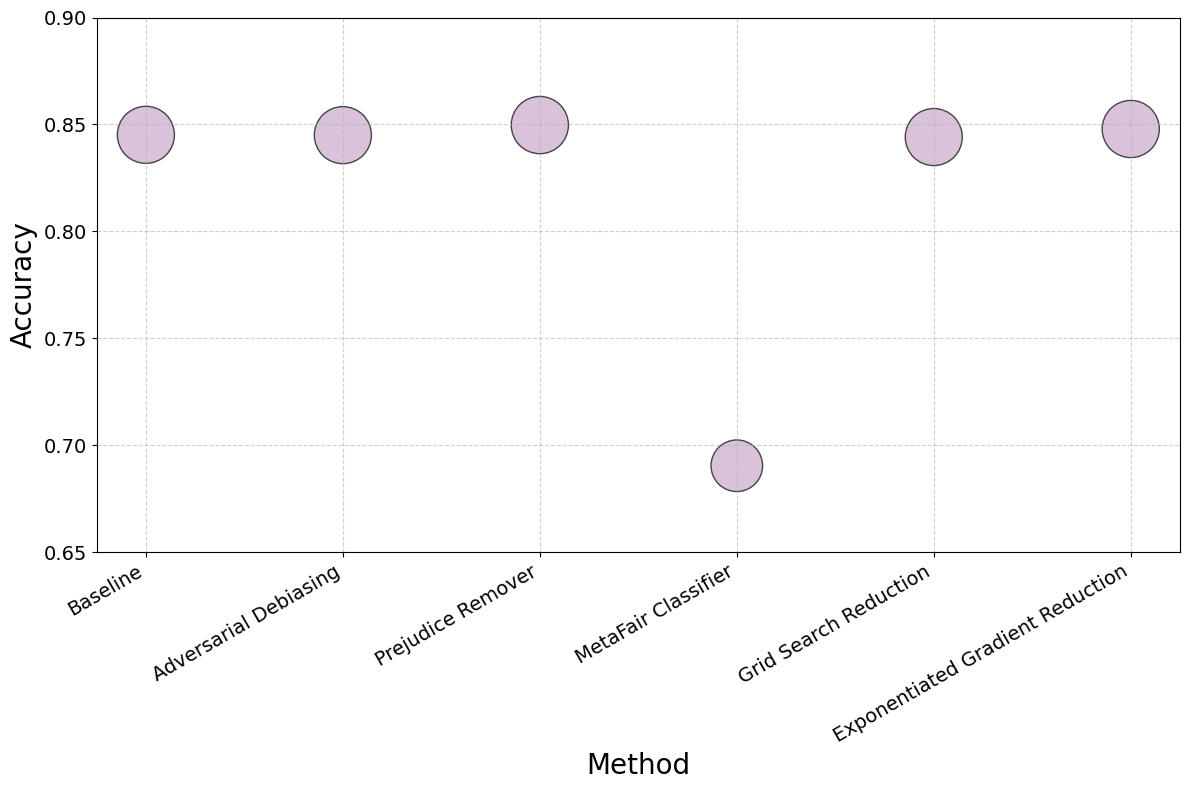

In [15]:
import matplotlib.pyplot as plt

methods = [
    "Baseline",
    "Adversarial Debiasing",
    "Prejudice Remover",
    "MetaFair Classifier",
    "Grid Search Reduction",
    "Exponentiated Gradient Reduction"
]
accuracy = [0.845139, 0.844992, 0.849709, 0.690425, 0.844107, 0.847866]

sizes = [a*2000 for a in accuracy]  # bubble size proportional to accuracy

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(methods, accuracy, s=sizes, color="#CBAACB", alpha=0.7, edgecolor="black")

plt.xlabel("Method", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.xticks(rotation=30, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.65, 0.9)
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()




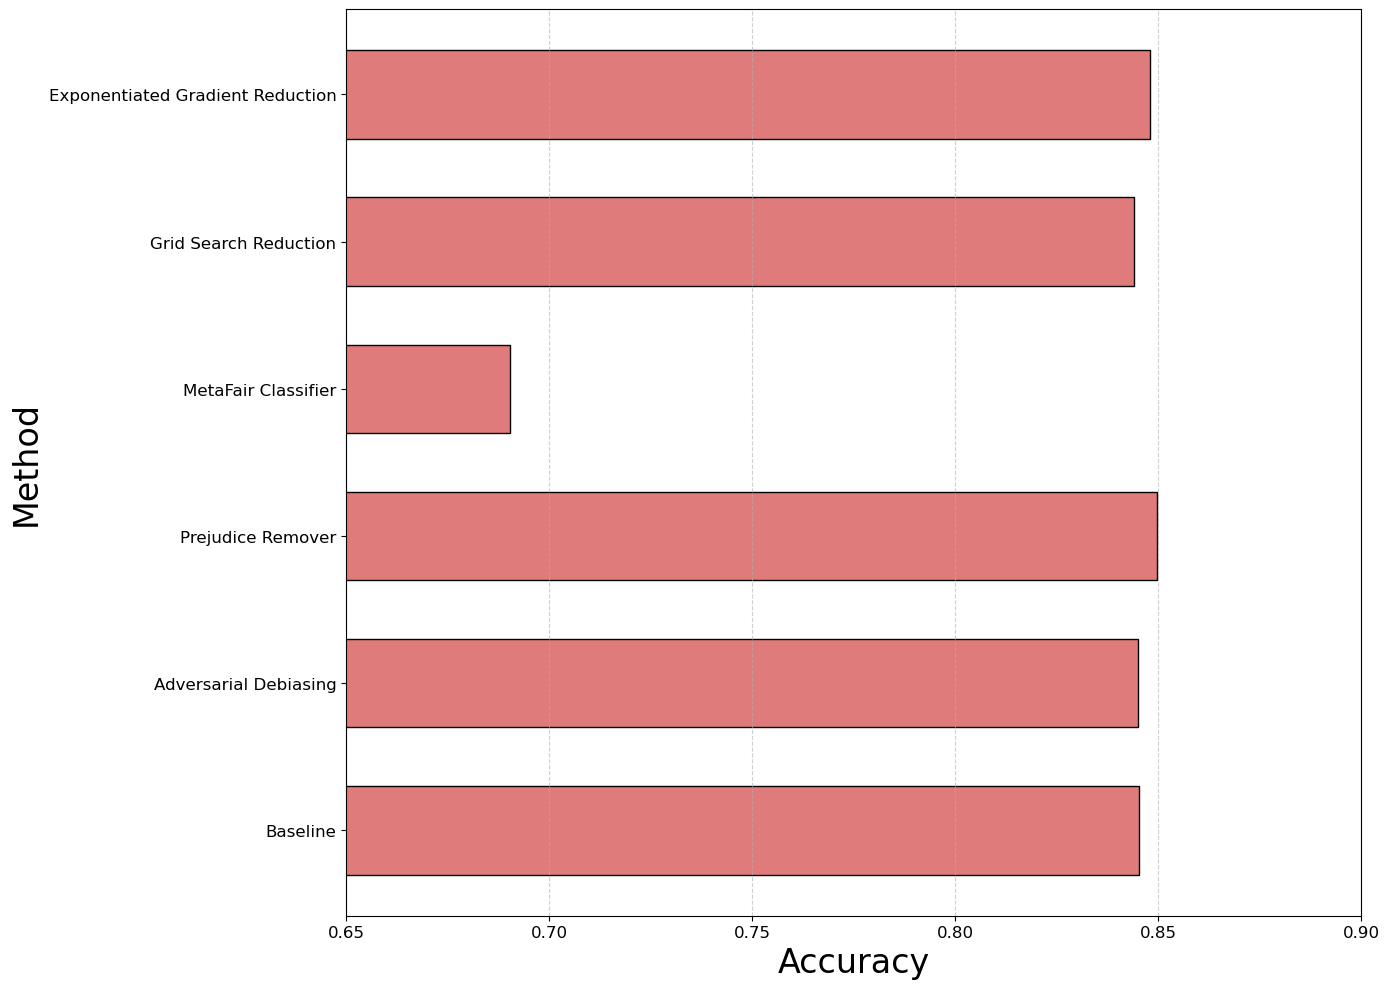

AttributeError: module 'matplotlib.pyplot' has no attribute 'savefigure'

In [5]:
import matplotlib.pyplot as plt

methods = [
    "Baseline",
    "Adversarial Debiasing",
    "Prejudice Remover",
    "MetaFair Classifier",
    "Grid Search Reduction",
    "Exponentiated Gradient Reduction"
]
accuracy = [0.845139, 0.844992, 0.849709, 0.690425, 0.844107, 0.847866]

# Darker pastel palette (different shade per bar)
colors = ["#E07B7B"]

fig, ax = plt.subplots(figsize=(14,10))
bars = ax.barh(methods, accuracy, color=colors, edgecolor="black", height=0.6)

# Labels
plt.xlabel("Accuracy", fontsize=24)
plt.ylabel("Method", fontsize=24)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(0.65, 0.9)
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
plt.savefigure()


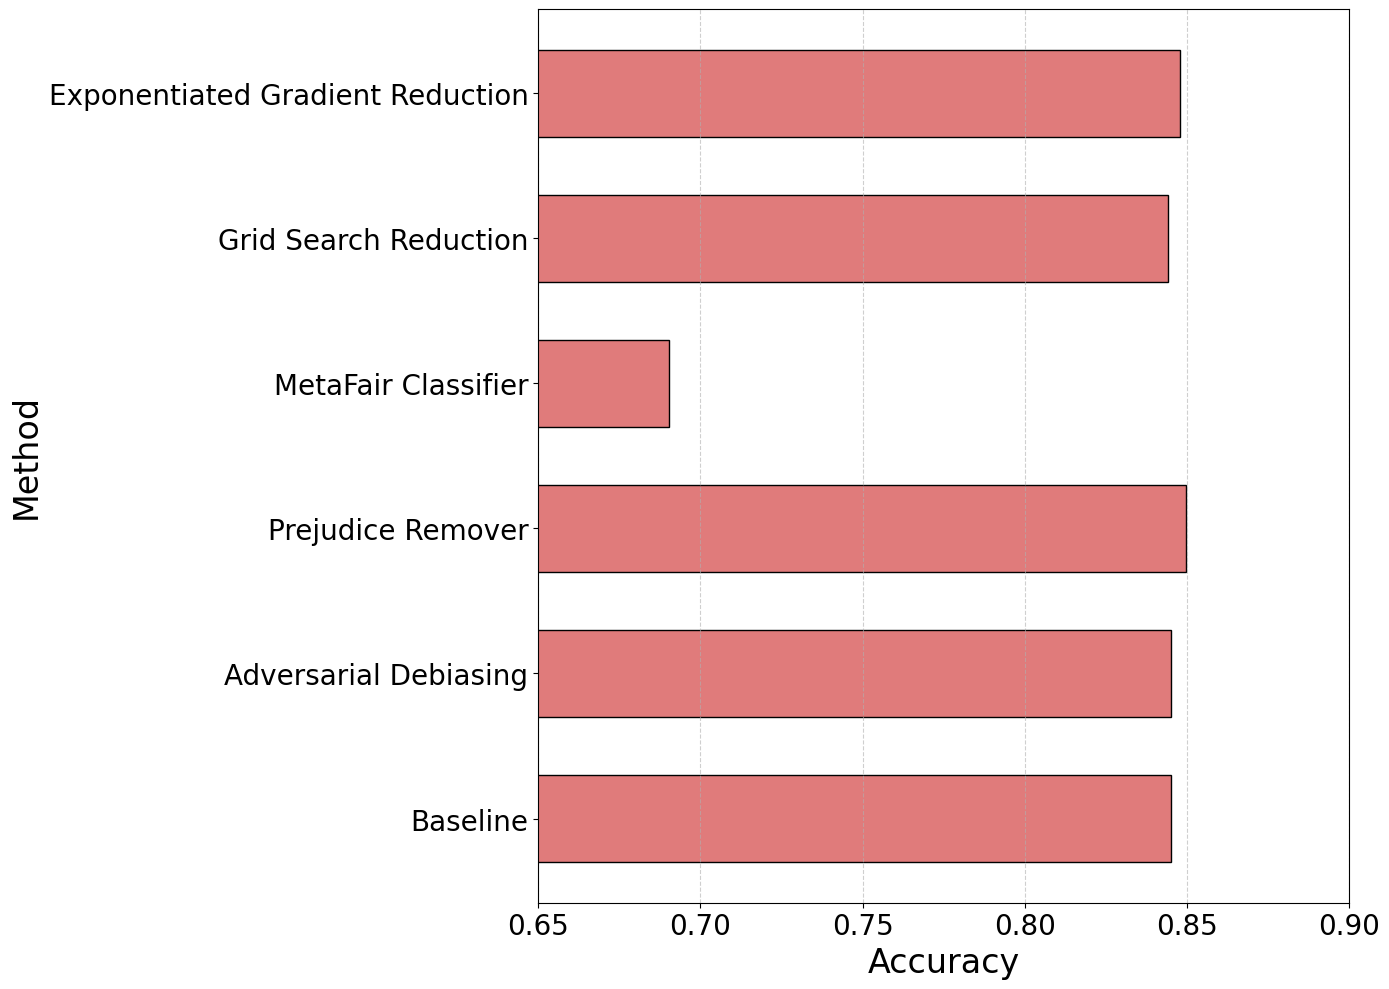

✅ Figure saved as Accuracy_HorizontalBar.png


In [7]:
import matplotlib.pyplot as plt

# ================================
# Data
# ================================
methods = [
    "Baseline",
    "Adversarial Debiasing",
    "Prejudice Remover",
    "MetaFair Classifier",
    "Grid Search Reduction",
    "Exponentiated Gradient Reduction"
]
accuracy = [0.845139, 0.844992, 0.849709, 0.690425, 0.844107, 0.847866]

# ================================
# Plot
# ================================
colors = ["#E07B7B"] * len(methods)

fig, ax = plt.subplots(figsize=(14, 10))
bars = ax.barh(methods, accuracy, color=colors, edgecolor="black", height=0.6)

# Labels & Styling
plt.xlabel("Accuracy", fontsize=24)
plt.ylabel("Method", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0.65, 0.9)
plt.grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()

# ================================
# Save & Show
# ================================
plt.savefig("Accuracy_HorizontalBar.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Figure saved as Accuracy_HorizontalBar.png")


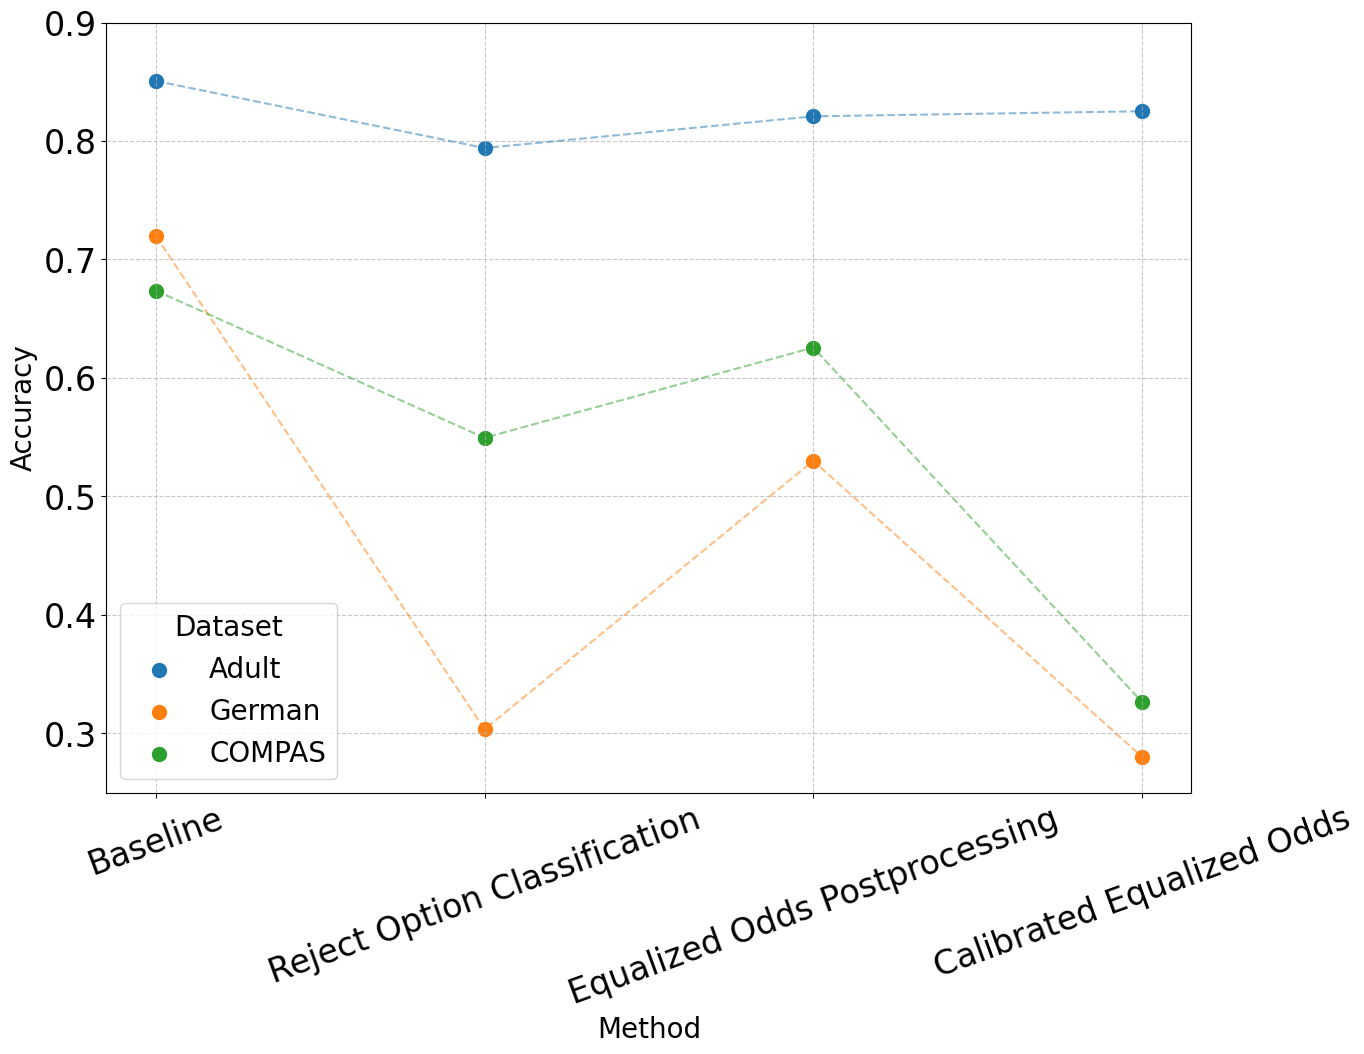

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# ================================
# Data from your tables
# ================================
data = {
    "Method": [
        "Baseline",
        "Reject Option Classification",
        "Equalized Odds Postprocessing",
        "Calibrated Equalized Odds"
    ],
    "Adult": [0.850667, 0.794059, 0.820815, 0.825090],
    "German": [0.720000, 0.303333, 0.530000, 0.280000],
    "COMPAS": [0.673690, 0.549433, 0.625608, 0.326310]
}

df = pd.DataFrame(data)


fig, ax = plt.subplots(figsize=(14,10))
methods = df["Method"]

for col in ["Adult", "German", "COMPAS"]:
    ax.scatter(methods, df[col], label=col, s=100)  # dots
    ax.plot(methods, df[col], linestyle="--", alpha=0.5)  # connectors

plt.ylabel("Accuracy", fontsize=20)
plt.xlabel("Method", fontsize=20)
plt.xticks(rotation=20, fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(0.25, 0.9)
plt.legend(title="Dataset", fontsize=20, title_fontsize=20)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()



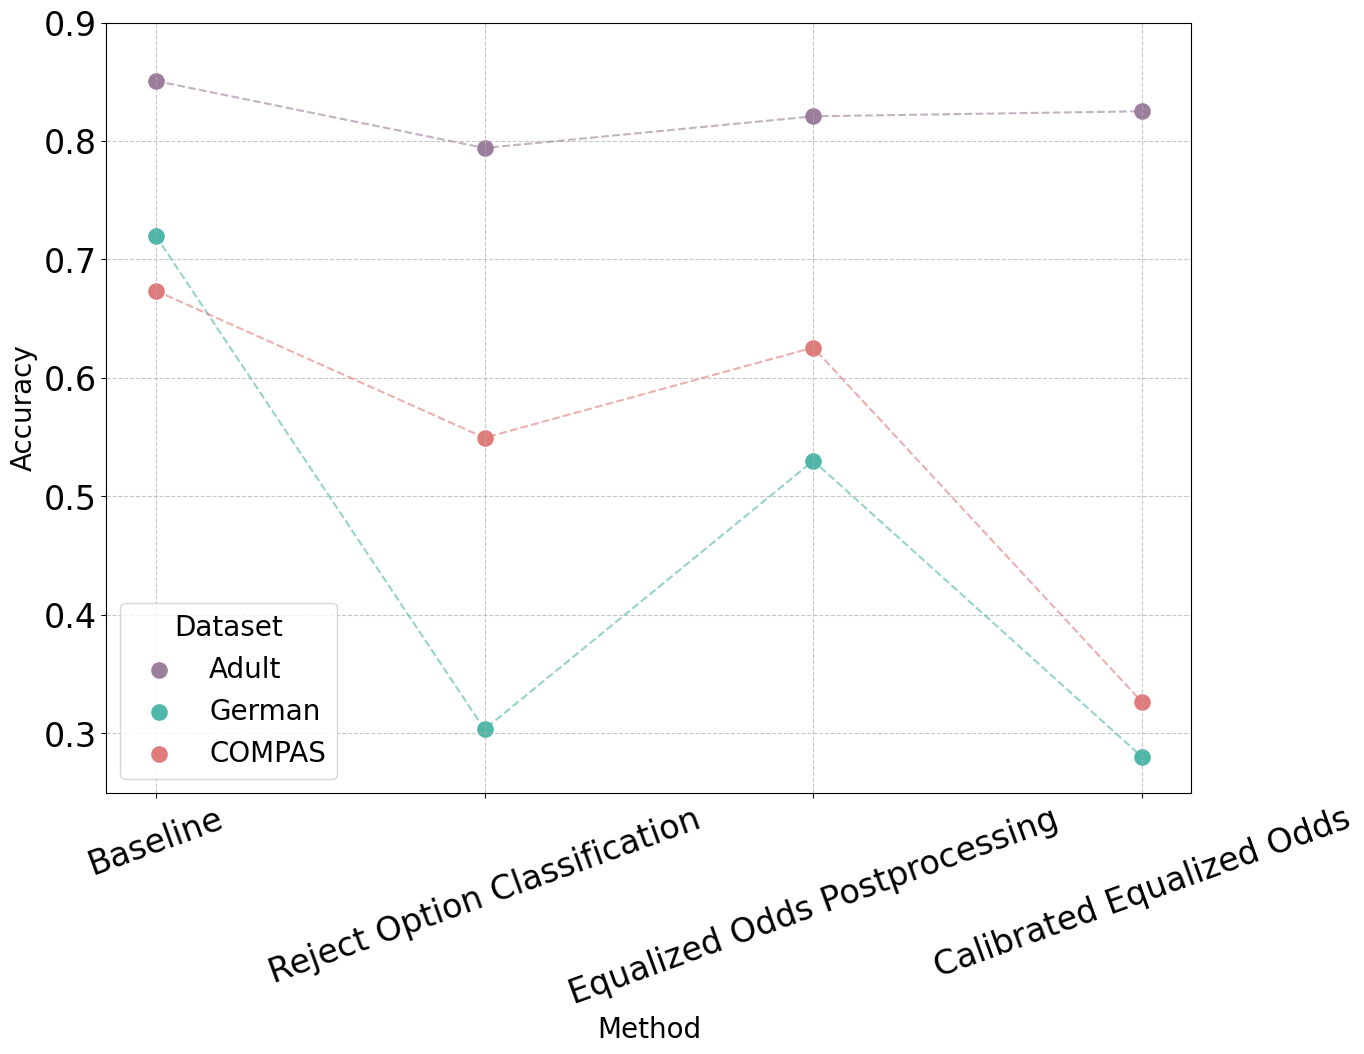

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# ================================
# Data
# ================================
data = {
    "Method": [
        "Baseline",
        "Reject Option Classification",
        "Equalized Odds Postprocessing",
        "Calibrated Equalized Odds"
    ],
    "Adult": [0.850667, 0.794059, 0.820815, 0.825090],
    "German": [0.720000, 0.303333, 0.530000, 0.280000],
    "COMPAS": [0.673690, 0.549433, 0.625608, 0.326310]
}

df = pd.DataFrame(data)

# ================================
# Plot
# ================================
fig, ax = plt.subplots(figsize=(14,10))
methods = df["Method"]

# Pastel color palette (lavender, teal, rose)
colors = {
    "Adult": "#9B7E9B",   # lavender
    "German": "#4FB7A8",  # teal
    "COMPAS": "#E07B7B"   # rose
}

for col in ["Adult", "German", "COMPAS"]:
    ax.scatter(methods, df[col], label=col, s=120, color=colors[col])
    ax.plot(methods, df[col], linestyle="--", alpha=0.6, color=colors[col])

plt.ylabel("Accuracy", fontsize=20)
plt.xlabel("Method", fontsize=20)
plt.xticks(rotation=20, fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(0.25, 0.9)
plt.legend(title="Dataset", fontsize=20, title_fontsize=20)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()
